# Project 1 - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

In [40]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Import stuff relevant to HTML scraping
import requests
import re

In [41]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Exercise 1 

In [42]:
save_plots = True

In [43]:
# Creating paths to the html files
# Downloaded from https://kenpom.com/ and saved in the same folder as this script 8-Feb-2024
path_09 = '2009_Pomeroy_College_Basketball_Ratings.html'
path_14 = '2014_Pomeroy_College_Basketball_Ratings.html'

# The index of the header to make column names in the html file
N_header = 17

# Skipping the rows, where the header repeats itself. Index found by inspection
skip_rows_idx = np.array([40, 41, 82, 83, 124, 125, 166, 167, 208, 209, 250, 251, 292, 293, 334, 335])

# Adding the number of header rows to the index of the rows to skip (to account for the header)
skip_rows_idx += N_header + 1

# Reading the html files into pandas dataframes
df_09 = pd.read_html(path_09, header = N_header, skiprows = skip_rows_idx)[0]
df_14 = pd.read_html(path_14, header = N_header, skiprows = skip_rows_idx)[0]

# Test we have the right number of teams
N_teams_09 = len(df_09)
N_teams_14 = len(df_14)
print(f'Pandas found {N_teams_09} teams in 2009 and {N_teams_14} in 2014')

Pandas found 344 teams in 2009 and 351 in 2014


In [44]:
def adjusted_defence(conf, year): 
    """Returns the adjusted defence for the teams in the conference in the given year."""

    if year == 2009:
        df = df_09
    else:
        df = df_14

    # Selecting the adjusted defence for the teams in the conference
    AdjD = df['AdjD'][df['Conf'] == conf]

    return AdjD.to_numpy()

In [45]:
# Defining the five conferences we are interested in and getting the adjusted defence for the teams in the conferences
conference = np.array(['ACC', 'SEC', 'B10', 'BSky', 'A10'])
AdjD_14 = [adjusted_defence(conf, 2014) for conf in conference]

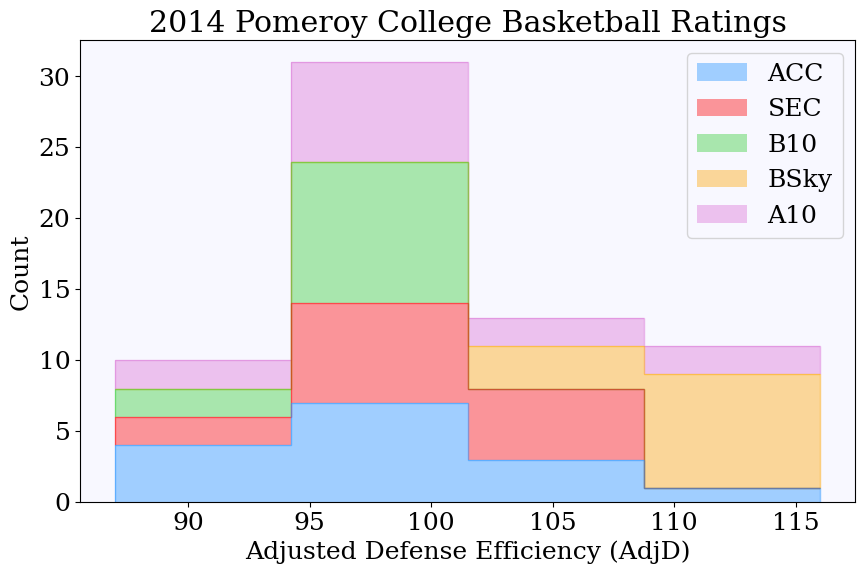

In [46]:
# Plotting the adjusted defence for the teams in the conferences
colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid']

N_bins = np.linspace(87, 116, 5)

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(AdjD_14 , bins=N_bins, color=colors, alpha=0.4, histtype='barstacked', label=conference)
ax.hist(AdjD_14 , bins=N_bins, color=colors, alpha=0.5, histtype='step', stacked=True)

ax.set(xlabel= 'Adjusted Defense Efficiency (AdjD)',
       ylabel= 'Count',
       title= '2014 Pomeroy College Basketball Ratings')
ax.legend()

if save_plots:
    plt.savefig('AdjD_2014.png', dpi=300)

# Exercise 2

To be able to calculate the difference in Adjusted Offence for the teams in the five conferences in 2009 and 2014, we first have to establish if the teams were participating in both 2009 and 2014 and if they were in the same conference both years. 

In [47]:
# Remove all characters that are not letters from the team names to make them comparable
df_09['Team'] = df_09['Team'].str.replace('[^A-Za-z]', '', regex=True) 
df_14['Team'] = df_14['Team'].str.replace('[^A-Za-z]', '', regex=True)

# Compute the number of unique teams in both years 
all_teams_09 = df_09['Team'].to_numpy()
all_teams_14 = df_14['Team'].to_numpy()
test = np.concatenate([all_teams_09, all_teams_14])
test_uniq = np.unique(test)

print(f'There are {len(test_uniq)} unique teams in the two years')
print(f'As there is more unique teams than the number of teams in each year, we have some teams that were not participating both years')

There are 353 unique teams in the two years
As there is more unique teams than the number of teams in each year, we have some teams that were not participating both years


In [48]:
# Find the teams that were not participating both years
teams_not_in_09 = np.setdiff1d(all_teams_14, all_teams_09)
teams_not_in_14 = np.setdiff1d(all_teams_09, all_teams_14)

print(f'The {len(teams_not_in_09)} teams not participating in 2009: {teams_not_in_09}')
print(f'The {len(teams_not_in_14)} teams not participating in 2014: {teams_not_in_14} \n')

print(f'As the {len(teams_not_in_09)+len(teams_not_in_14)} teams are not participating both years, we have to remove them from the analysis')

The 9 teams not participating in 2009: ['AbileneChristian' 'GrandCanyon' 'IncarnateWord' 'NebraskaOmaha'
 'NorthDakota' 'NorthernKentucky' 'Seattle' 'SouthDakota' 'UMassLowell']
The 2 teams not participating in 2014: ['Centenary' 'WinstonSalemSt'] 

As the 11 teams are not participating both years, we have to remove them from the analysis


In [49]:
# Exclude the teams that were not participating both years and those not in the selected conferences
selected_teams = df_09['Team'][~df_09['Team'].isin(teams_not_in_14)][df_09['Conf'].isin(conference)].to_numpy()

# Find if the teams were in the same conference both years. 
# Boolean array to mask the teams that were in the same conference both years
same_conf = np.zeros(len(selected_teams))

for i in range(len(selected_teams)):
    conf_09 = df_09['Conf'][df_09['Team'] == selected_teams[i]].to_numpy()
    conf_14 = df_14['Conf'][df_14['Team'] == selected_teams[i]].to_numpy()
    same_conf[i] = (conf_09 == conf_14)

print(f'Of the {len(selected_teams)} teams participating both years in the selected conferences, {int(np.sum(same_conf))} were in the same conference both years')

Of the 58 teams participating both years in the selected conferences, 55 were in the same conference both years


In [50]:
def difference_in_AdjO(teams): 
    """Returns the difference in adjusted offence for the team in 2009 and 2014."""

    vals = []

    for i in range(len(teams)): 
        AdjO_09 = df_09['AdjO'][df_09['Team'] == teams[i]].to_numpy()
        AdjO_14 = df_14['AdjO'][df_14['Team'] == teams[i]].to_numpy()
        Conf = df_09['Conf'][df_09['Team'] == teams[i]].to_numpy()

        vals.append(np.array([AdjO_09, AdjO_14 - AdjO_09, Conf]))

    return vals

In [51]:
# Selecting the teams that were in the same conference both years
teams_same_conf = selected_teams[same_conf.astype(bool)]

# Sorting the teams into conferences
teams_sorted_conf = []

for i in range(len(conference)):
    conf_teams = []

    for j in range(len(teams_same_conf)):
        if df_09['Conf'][df_09['Team'] == teams_same_conf[j]].to_numpy() == conference[i]:
            conf_teams.append(teams_same_conf[j])
    
    teams_sorted_conf.append(conf_teams)

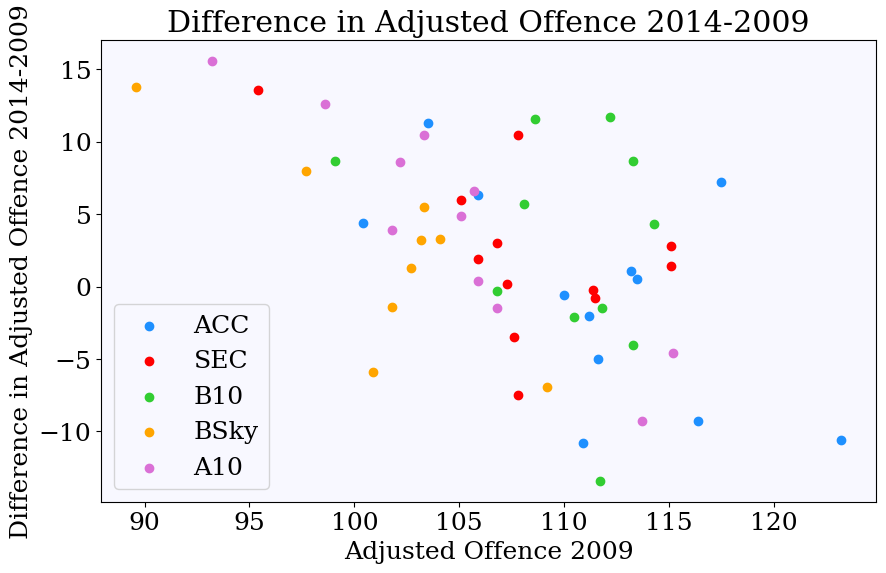

In [52]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(conference)):
    diff_AdjO = difference_in_AdjO(teams_sorted_conf[i])
    diff_AdjO = np.array(diff_AdjO).squeeze()

    ax.scatter(diff_AdjO[:,0], diff_AdjO[:,1], label=conference[i], color=colors[i])

ax.set(xlabel= 'Adjusted Offence 2009',
         ylabel= 'Difference in Adjusted Offence 2014-2009',
         title= 'Difference in Adjusted Offence 2014-2009')
ax.legend()

if save_plots:
    plt.savefig('Diff_AdjO.png', dpi=300)

In [53]:
# Calculate the mean and median for the difference in adjusted offence for the teams in the selected conferences seperately
mean_diff_AdjO = []
median_diff_AdjO = []

for i in range(len(conference)):
    diff_AdjO = difference_in_AdjO(teams_sorted_conf[i])
    diff_AdjO = np.array(diff_AdjO).squeeze()

    mean_diff_AdjO.append(np.mean(diff_AdjO[:,1]))
    median_diff_AdjO.append(np.median(diff_AdjO[:,1]))

    print(f'For the {len(teams_sorted_conf[i])} teams in the {conference[i]} conference: \
           \t mean = {mean_diff_AdjO[i]:.3f} \t median = {median_diff_AdjO[i]:.3f}')

For the 12 teams in the ACC conference:            	 mean = -0.625 	 median = -0.050
For the 12 teams in the SEC conference:            	 mean = 2.283 	 median = 1.650
For the 11 teams in the B10 conference:            	 mean = 2.673 	 median = 4.300
For the 9 teams in the BSky conference:            	 mean = 2.322 	 median = 3.200
For the 11 teams in the A10 conference:            	 mean = 4.336 	 median = 4.900


In [54]:
# Calculate the mean and median for the difference in adjusted offence for the teams not in the selected conferences
# Still excluding the teams that were not participating both years

# Find the conferences not in the initially selected conferences
new_conference = np.setdiff1d(df_09['Conf'].to_numpy(), conference)

# Exclude conferences not present both years
new_conference = np.intersect1d(new_conference, df_14['Conf'].to_numpy())

print(f'There is {len(new_conference)} conferences not in the initially selected conferences in both years')

# Exclude the teams not participating both years and those in the initially selected conferences
new_selected_teams = df_09['Team'][~df_09['Team'].isin(teams_not_in_14)][df_09['Conf'].isin(new_conference)].to_numpy()

print(f'There is {len(new_selected_teams)} teams in the {len(new_conference)} conferences not in the initially selected conferences')

# Find if the teams were in the same conference both years. 
# Boolean array to mask the teams that were in the same conference both years
new_same_conf = np.zeros(len(new_selected_teams))

for i in range(len(new_selected_teams)):
    new_conf_09 = df_09['Conf'][df_09['Team'] == new_selected_teams[i]].to_numpy()
    new_conf_14 = df_14['Conf'][df_14['Team'] == new_selected_teams[i]].to_numpy()
    new_same_conf[i] = (new_conf_09 == new_conf_14)

print(f'Of the {len(new_selected_teams)} teams participating both years in the {len(new_conference)} conferences, {int(np.sum(new_same_conf))} were in the same conference both years')

# Selecting the teams that were in the same conference both years
new_teams_same_conf = new_selected_teams[new_same_conf.astype(bool)]

print(f'There is {len(new_teams_same_conf)} teams participating both years in the {len(new_conference)} conferences')

# Sorting the teams into conferences
new_teams_sorted_conf = []

for i in range(len(new_conference)):
    new_conf_teams = []

    for j in range(len(new_teams_same_conf)):
        if df_09['Conf'][df_09['Team'] == new_teams_same_conf[j]].to_numpy() == new_conference[i]:
            new_conf_teams.append(new_teams_same_conf[j])
    
    new_teams_sorted_conf.append(new_conf_teams)

# Calculate the mean and median for the difference in adjusted offence for the teams in the selected conferences seperately
new_mean_diff_AdjO = []
new_median_diff_AdjO = []

for i in range(len(new_conference)):

    if len(new_teams_sorted_conf[i]) > 1:

        new_diff_AdjO = difference_in_AdjO(new_teams_sorted_conf[i])
        new_diff_AdjO = np.array(new_diff_AdjO).squeeze()

        new_mean_diff_AdjO.append(np.mean(new_diff_AdjO[:,1]))
        new_median_diff_AdjO.append(np.median(new_diff_AdjO[:,1]))
    
    else:
        adjo_1 = df_14['AdjO'][df_14['Team'] == new_teams_sorted_conf[i][0]].to_numpy()
        adjo_2 = df_09['AdjO'][df_09['Team'] == new_teams_sorted_conf[i][0]].to_numpy()
        single_val = (adjo_1 - adjo_2)[-1]
        new_mean_diff_AdjO.append(single_val)
        new_median_diff_AdjO.append(single_val)

    print(f'For the {len(new_teams_sorted_conf[i])} teams in the {new_conference[i]} conference: \
           \t mean = {new_mean_diff_AdjO[i]:.3f} \t median = {new_median_diff_AdjO[i]:.3f}')

There is 26 conferences not in the initially selected conferences in both years
There is 274 teams in the 26 conferences not in the initially selected conferences
Of the 274 teams participating both years in the 26 conferences, 209 were in the same conference both years
There is 209 teams participating both years in the 26 conferences
For the 8 teams in the AE conference:            	 mean = -0.800 	 median = -0.450
For the 9 teams in the ASun conference:            	 mean = 3.289 	 median = 2.400
For the 8 teams in the B12 conference:            	 mean = 2.850 	 median = 0.850
For the 7 teams in the BE conference:            	 mean = 1.143 	 median = 1.900
For the 10 teams in the BSth conference:            	 mean = 4.200 	 median = 3.350
For the 8 teams in the BW conference:            	 mean = 1.713 	 median = 0.800
For the 8 teams in the CAA conference:            	 mean = 4.150 	 median = 6.900
For the 8 teams in the CUSA conference:            	 mean = -2.550 	 median = -3.650
Fo

# Exercise 3

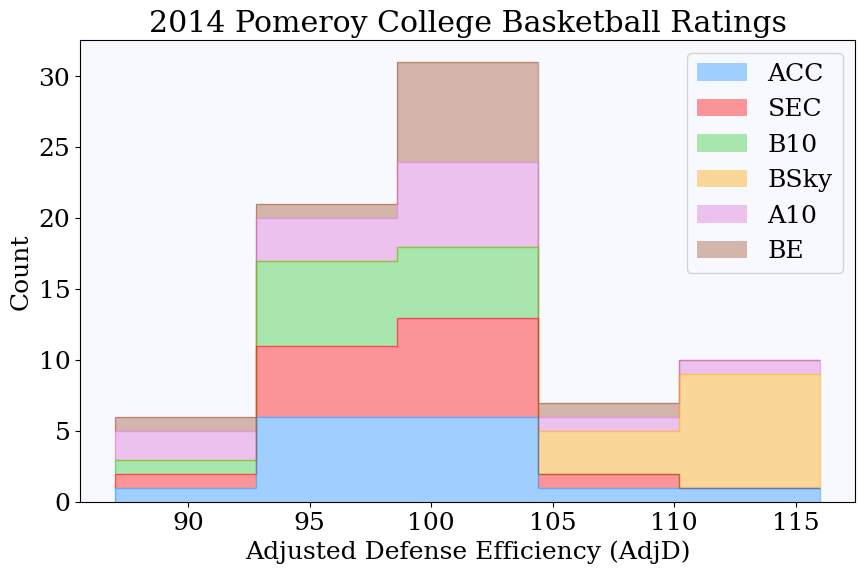

In [55]:
# Repeating exercise 1 - incl. 'BE' conference

# Defining the five conferences we are interested in and getting the adjusted defence for the teams in the conferences
conference_01 = np.array(['ACC', 'SEC', 'B10', 'BSky', 'A10', 'BE'])
AdjD_14_01 = [adjusted_defence(conf, 2014) for conf in conference_01]

# Plotting the adjusted defence for the teams in the conferences
colors_01=['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'sienna']
N_bins = np.linspace(87, 116, 6)

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(AdjD_14_01 , bins=N_bins, color=colors_01, alpha=0.4, histtype='barstacked', label=conference_01)
ax.hist(AdjD_14_01 , bins=N_bins, color=colors_01, alpha=0.5, histtype='step', stacked=True)

ax.set(xlabel= 'Adjusted Defense Efficiency (AdjD)',
       ylabel= 'Count',
       title= '2014 Pomeroy College Basketball Ratings')
ax.legend()

if save_plots:
    plt.savefig('AdjD_2014_01.png', dpi=300)

Of the 74 teams participating both years in the selected conferences, 62 were in the same conference both years


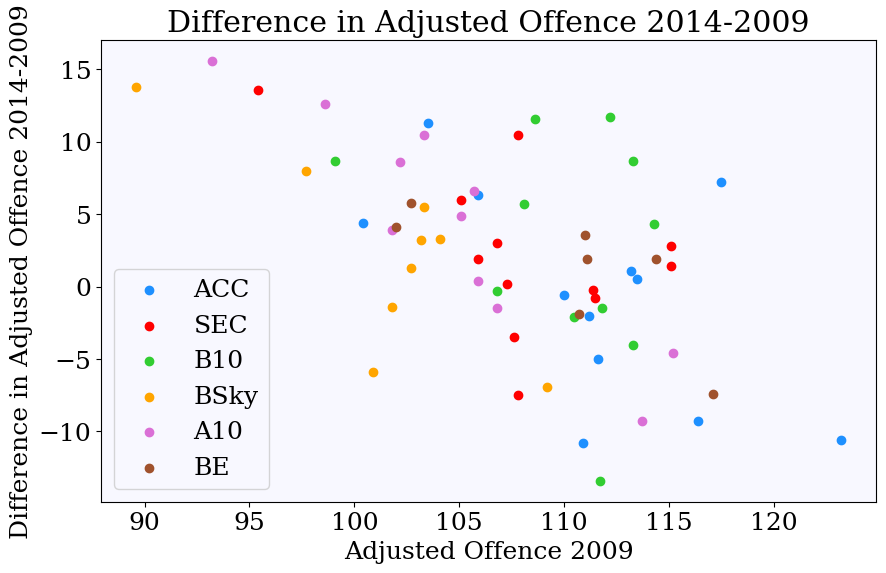

In [56]:
# Repeating exercise 2 - incl. 'BE' conference

# Exclude the teams that were not participating both years and those not in the selected conferences
selected_teams_01 = df_09['Team'][~df_09['Team'].isin(teams_not_in_14)][df_09['Conf'].isin(conference_01)].to_numpy()

# Find if the teams were in the same conference both years. 
# Boolean array to mask the teams that were in the same conference both years
same_conf_01 = np.zeros(len(selected_teams_01))

for i in range(len(selected_teams_01)):
    conf_09 = df_09['Conf'][df_09['Team'] == selected_teams_01[i]].to_numpy()
    conf_14 = df_14['Conf'][df_14['Team'] == selected_teams_01[i]].to_numpy()
    same_conf_01[i] = (conf_09 == conf_14)

print(f'Of the {len(selected_teams_01)} teams participating both years in the selected conferences, {int(np.sum(same_conf_01))} were in the same conference both years')

# Selecting the teams that were in the same conference both years
teams_same_conf_01 = selected_teams_01[same_conf_01.astype(bool)]

# Sorting the teams into conferences
teams_sorted_conf_01 = []

for i in range(len(conference_01)):
    conf_teams_01 = []

    for j in range(len(teams_same_conf_01)):
        if df_09['Conf'][df_09['Team'] == teams_same_conf_01[j]].to_numpy() == conference_01[i]:
            conf_teams_01.append(teams_same_conf_01[j])
    
    teams_sorted_conf_01.append(conf_teams_01)

# Plotting
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(conference_01)):
    diff_AdjO = difference_in_AdjO(teams_sorted_conf_01[i])
    diff_AdjO = np.array(diff_AdjO).squeeze()

    ax.scatter(diff_AdjO[:,0], diff_AdjO[:,1], label=conference_01[i], color=colors_01[i])

ax.set(xlabel= 'Adjusted Offence 2009',
         ylabel= 'Difference in Adjusted Offence 2014-2009',
         title= 'Difference in Adjusted Offence 2014-2009')
ax.legend()

if save_plots:
    plt.savefig('Diff_AdjO_01.png', dpi=300)

In [57]:
# Calculate the mean and median for the difference in adjusted offence for the teams in the selected conferences seperately
mean_diff_AdjO_01 = []
median_diff_AdjO_01 = []

for i in range(len(conference_01)):
    diff_AdjO = difference_in_AdjO(teams_sorted_conf_01[i])
    diff_AdjO = np.array(diff_AdjO).squeeze()

    mean_diff_AdjO_01.append(np.mean(diff_AdjO[:,1]))
    median_diff_AdjO_01.append(np.median(diff_AdjO[:,1]))

    print(f'For the {len(teams_sorted_conf_01[i])} teams in the {conference_01[i]} conference: \
           \t mean = {mean_diff_AdjO_01[i]:.3f} \t median = {median_diff_AdjO_01[i]:.3f}')

For the 12 teams in the ACC conference:            	 mean = -0.625 	 median = -0.050
For the 12 teams in the SEC conference:            	 mean = 2.283 	 median = 1.650
For the 11 teams in the B10 conference:            	 mean = 2.673 	 median = 4.300
For the 9 teams in the BSky conference:            	 mean = 2.322 	 median = 3.200
For the 11 teams in the A10 conference:            	 mean = 4.336 	 median = 4.900
For the 7 teams in the BE conference:            	 mean = 1.143 	 median = 1.900


In [58]:
# Calculate the mean and median for the difference in adjusted offence for the teams not in the selected conferences
# Still excluding the teams that were not participating both years

# Find the conferences not in the initially selected conferences
new_conference_01 = np.setdiff1d(df_09['Conf'].to_numpy(), conference_01)

# Exclude conferences not present both years
new_conference_01 = np.intersect1d(new_conference_01, df_14['Conf'].to_numpy())

print(f'There is {len(new_conference_01)} conferences not in the initially selected conferences in both years')

# Exclude the teams not participating both years and those in the initially selected conferences
new_selected_teams_01 = df_09['Team'][~df_09['Team'].isin(teams_not_in_14)][df_09['Conf'].isin(new_conference_01)].to_numpy()

print(f'There is {len(new_selected_teams_01)} teams in the {len(new_conference_01)} conferences not in the initially selected conferences')

# Find if the teams were in the same conference both years. 
# Boolean array to mask the teams that were in the same conference both years
new_same_conf_01 = np.zeros(len(new_selected_teams_01))

for i in range(len(new_selected_teams_01)):
    new_conf_09 = df_09['Conf'][df_09['Team'] == new_selected_teams_01[i]].to_numpy()
    new_conf_14 = df_14['Conf'][df_14['Team'] == new_selected_teams_01[i]].to_numpy()
    new_same_conf_01[i] = (new_conf_09 == new_conf_14)

print(f'Of the {len(new_selected_teams_01)} teams participating both years in the {len(new_conference_01)} conferences, {int(np.sum(new_same_conf_01))} were in the same conference both years')

# Selecting the teams that were in the same conference both years
new_teams_same_conf_01 = new_selected_teams_01[new_same_conf_01.astype(bool)]

print(f'There is {len(new_teams_same_conf_01)} teams participating both years in the {len(new_conference_01)} conferences')

# Sorting the teams into conferences
new_teams_sorted_conf_01 = []

for i in range(len(new_conference_01)):
    new_conf_teams = []

    for j in range(len(new_teams_same_conf_01)):
        if df_09['Conf'][df_09['Team'] == new_teams_same_conf_01[j]].to_numpy() == new_conference_01[i]:
            new_conf_teams.append(new_teams_same_conf[j])
    
    new_teams_sorted_conf_01.append(new_conf_teams)

# Calculate the mean and median for the difference in adjusted offence for the teams in the selected conferences seperately
new_mean_diff_AdjO_01 = []
new_median_diff_AdjO_01 = []

for i in range(len(new_conference_01)):

    if len(new_teams_sorted_conf_01[i]) > 1:

        new_diff_AdjO = difference_in_AdjO(new_teams_sorted_conf_01[i])
        new_diff_AdjO = np.array(new_diff_AdjO).squeeze()

        new_mean_diff_AdjO_01.append(np.mean(new_diff_AdjO[:,1]))
        new_median_diff_AdjO_01.append(np.median(new_diff_AdjO[:,1]))
    
    else:
        adjo_1 = df_14['AdjO'][df_14['Team'] == new_teams_sorted_conf_01[i][0]].to_numpy()
        adjo_2 = df_09['AdjO'][df_09['Team'] == new_teams_sorted_conf_01[i][0]].to_numpy()
        single_val = (adjo_1 - adjo_2)[-1]
        new_mean_diff_AdjO_01.append(single_val)
        new_median_diff_AdjO_01.append(single_val)

    print(f'For the {len(new_teams_sorted_conf_01[i])} teams in the {new_conference_01[i]} conference: \
           \t mean = {new_mean_diff_AdjO_01[i]:.3f} \t median = {new_median_diff_AdjO_01[i]:.3f}')

There is 25 conferences not in the initially selected conferences in both years
There is 258 teams in the 25 conferences not in the initially selected conferences
Of the 258 teams participating both years in the 25 conferences, 202 were in the same conference both years
There is 202 teams participating both years in the 25 conferences
For the 8 teams in the AE conference:            	 mean = 4.800 	 median = 2.950
For the 9 teams in the ASun conference:            	 mean = 0.122 	 median = 0.300
For the 8 teams in the B12 conference:            	 mean = -0.613 	 median = -0.400
For the 10 teams in the BSth conference:            	 mean = 2.970 	 median = 0.650
For the 8 teams in the BW conference:            	 mean = 0.662 	 median = 1.550
For the 8 teams in the CAA conference:            	 mean = 1.162 	 median = 2.200
For the 8 teams in the CUSA conference:            	 mean = 0.113 	 median = 0.400
For the 8 teams in the Horz conference:            	 mean = -3.300 	 median = -5.750
